***Work Flow***

**First Cut**
*clean data*
Knn and mice
knnChoice, explaination
Kept mice for further experimentation

**Second Cut**
*interpret and feature ranking*
Plug into maps, visual represenation 

identify relationships
por-perm linear
Pvel, youngs, connecte to density

Feature ranking
graphs, partil vs reg, correclation coeffient
lack of outlyers
choice and why
validate with voilen and random regression

options open for further experimentation

**Third Cut**
*prediction models*
linear vs knn vs prediction tree vs random forest
Testing with various input
calucation and evauation of accucry via 


**First Cut**

At a glance, Maps

Clean data.
Looking over various ways to clean data, aka fill in missing values so we can plug itto prediction models.
sled hammer approteces such as cut features with missing data, replacing with constants, cut all wells with missing data, introduces biasis or leaves us with little to no data. 

Instead Knn or Mice 
KNN: For each missing value, finds the k-nearest samples (rows) with similar feature values (using available features), then imputes the missing value as the average (or weighted average) of those neighbors.
Pros: Simple and intuitive.Captures local structure in the data.
Cons: Can be slow for large datasets.Sensitive to the choice of k. Does not model relationships between features as explicitly as MICE.
MICE:Iteratively models each feature with missing values as a function of other features, using regression. Each missing value is imputed multiple times in a round-robin fashion until convergence.
Pros: Handles multivariate relationships between features. Can provide multiple imputed datasets for uncertainty estimation.More flexible for complex data patterns.
Cons: More computationally intensive.Requires careful parameter tuning.Can be sensitive to model assumptions.

choice and Why, KNN- for simplicty, mice isnt strictly nessacry becasue the data is nice and pretty, uncomplex, and small. only 73. Mice risks complicating things when knn is quote "perfectly fine" (Dr. Pyre) 
However, did both for future experimetation 
Final files: knn ==[text](Pyrcz_ebook/dataframe_imputed.csv)
             mice == [text](Pyrcz_ebook/dataframeMC_imputed.csv)


In [1]:
# code credited to Dr. Pyres, modified to data set
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn.impute import SimpleImputer                      # basic imputation method
from sklearn.impute import KNNImputer                         # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer     # required for MICE imputation
from sklearn.impute import IterativeImputer                   # MICE imputation
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for random numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 73071                                                  # random seed
np.random.seed(seed=seed)

In [2]:
def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [3]:
# code credited to Dr. Pyres, modified to data set
idata = 2

if idata == 0:
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub repository  
    df.drop('Prod',axis=1,inplace=True)

    features = df.columns.values.tolist()                          # store the names of the features
    
    xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minimum and maximum values for plotting

    flabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']

    ftitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
             'Total Organic Carbon','Vitrinite Reflectance']

elif idata == 1:
    names = {'Porosity':'Por'}
    
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load data from Dr. Pyrcz's GitHub repository  
    df = df.rename(columns=names)
    df['Por'] = df['Por'] * 100.0; df['AI'] = df['AI'] / 1000.0; 
    df.drop('Unnamed: 0',axis=1,inplace=True) 
    
    features = df.columns.values.tolist()                          # store the names of the features

    xmin = [0.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [10000.0,10000.0,1.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
    flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

    ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
              'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

elif idata == 2:  
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/res21_2D_wells.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    features = df.columns.values.tolist()                          # store the names of the features

    xmin = [1,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [73,10000.0,10000.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
    flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

    ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
              'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

In [4]:
# code credited to Dr. Pyres, modified to data set
if idata == 0 or idata == 1:
    proportion_NaN = 0.1                                          # proportion of values in DataFrame to remove
    np.random.seed(seed=seed)                                     # ensure repeatability
    remove = np.random.random(df.shape) < proportion_NaN          # make the boolean array for removal
    if idata == 1:
        remove[:,df.columns.get_loc('Facies')] = False            # avoid categoical imputation at this time          
    print('Fraction of removed values in mask ndarray = ' + str(round(remove.sum()/remove.size,3)) + '.')

    df_mask = df.mask(remove)
else:
    df_mask = df.copy(deep = True)

print('Fraction of nan values in the DataFrame = ' + str(round(df_mask.isnull().sum().sum()/(df_mask.shape[0]*df_mask.shape[1]),3)) + '.')

Fraction of nan values in the DataFrame = 0.105.


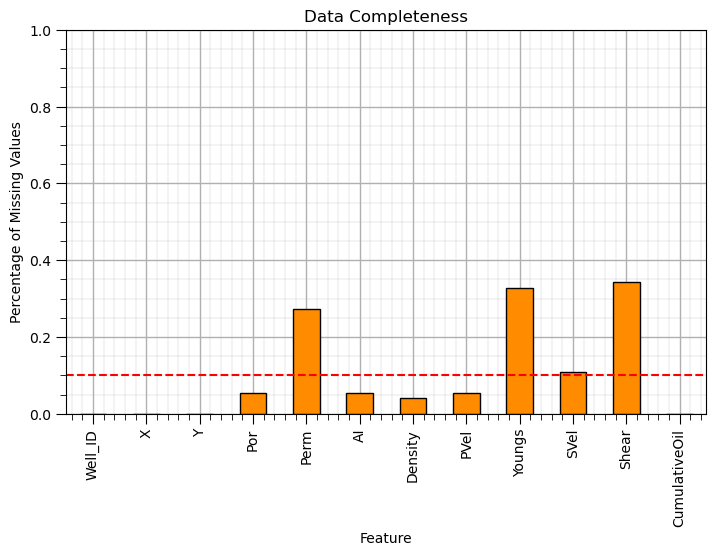

In [5]:
# code credited to Dr. Pyres, modified to data set
df_mask.head(n=13)   
df_mask.describe().transpose() 
plt.subplot(111)                                              # data completeness plot
(df_mask.isnull().sum()/len(df)).plot(kind = 'bar',color='darkorange',edgecolor='black') 
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.plot([-0.5,df.shape[1]+0.5],[0.1,0.1],color='red',ls='--')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); add_grid(); plt.show()

,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear,CumulativeOil,Imputed
0,1,7325.0,7175.0,13.564033,NaN,7.214987,2.153530,3379.255305,25.875998,1658.612455,NaN,847.33,True
1,2,4225.0,3525.0,12.907730,133.910637,7.308846,2.146360,3563.549461,25.688560,1673.770439,6.429229,1201.20,False
2,3,7725.0,8275.0,12.110566,104.059282,7.366451,1.919698,3882.442911,NaN,1675.645601,5.674798,781.40,True
3,4,4425.0,6475.0,13.990654,139.915993,7.286771,1.980721,3688.351168,27.125611,NaN,5.408664,1573.20,True
4,5,2125.0,1225.0,12.982720,NaN,7.333877,1.928716,3777.566423,28.133694,NaN,5.265054,548.68,True


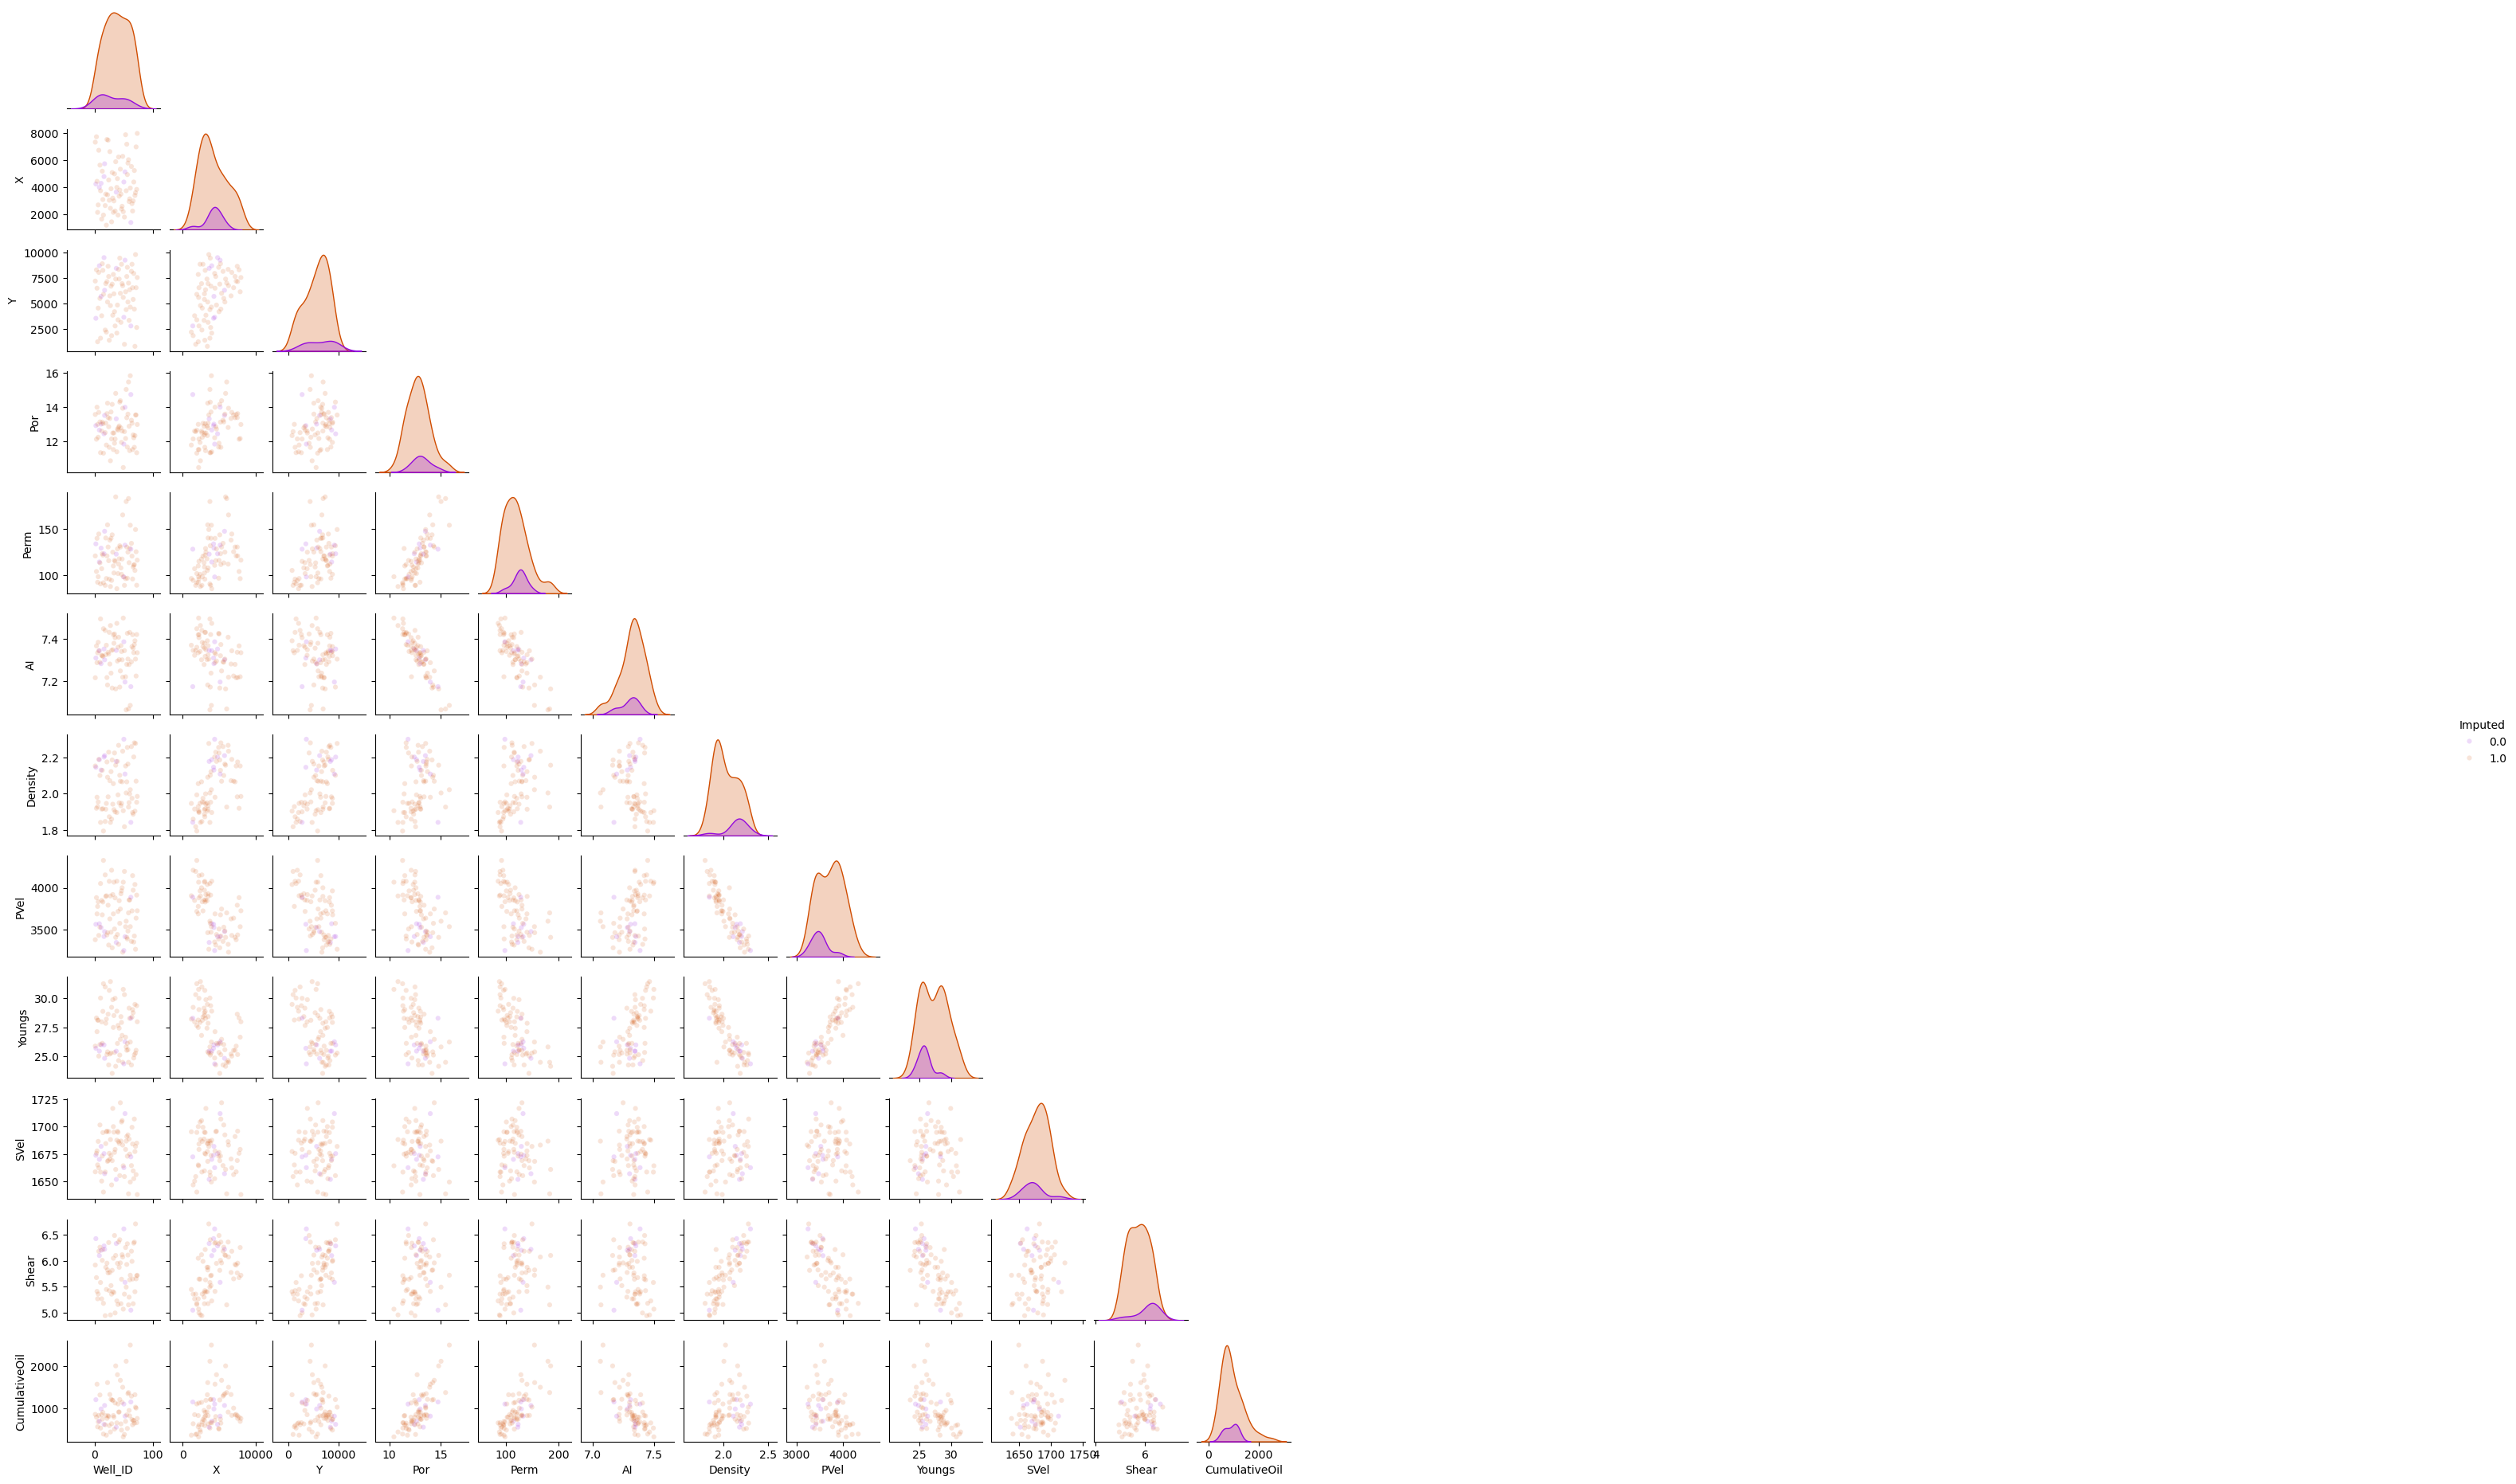

In [6]:
df_mask['Imputed'] = (df_mask.isnull().sum(axis=1)) > 0
df_mask.head()

df_knn = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

sns.pairplot(df_knn.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant = df_mask.copy(deep=True) 
df_mode = df_mask.copy(deep=True)  
df_constant.head(n=5)
df_mode.head(n=5)

,Well_ID,X,Y,Por,Perm,AI,Density,PVel,Youngs,SVel,Shear,CumulativeOil,Imputed
0,1,7325.0,7175.0,13.564033,NaN,7.214987,2.153530,3379.255305,25.875998,1658.612455,NaN,847.33,True
1,2,4225.0,3525.0,12.907730,133.910637,7.308846,2.146360,3563.549461,25.688560,1673.770439,6.429229,1201.20,False
2,3,7725.0,8275.0,12.110566,104.059282,7.366451,1.919698,3882.442911,NaN,1675.645601,5.674798,781.40,True
3,4,4425.0,6475.0,13.990654,139.915993,7.286771,1.980721,3688.351168,27.125611,NaN,5.408664,1573.20,True
4,5,2125.0,1225.0,12.982720,NaN,7.333877,1.928716,3777.566423,28.133694,NaN,5.265054,548.68,True


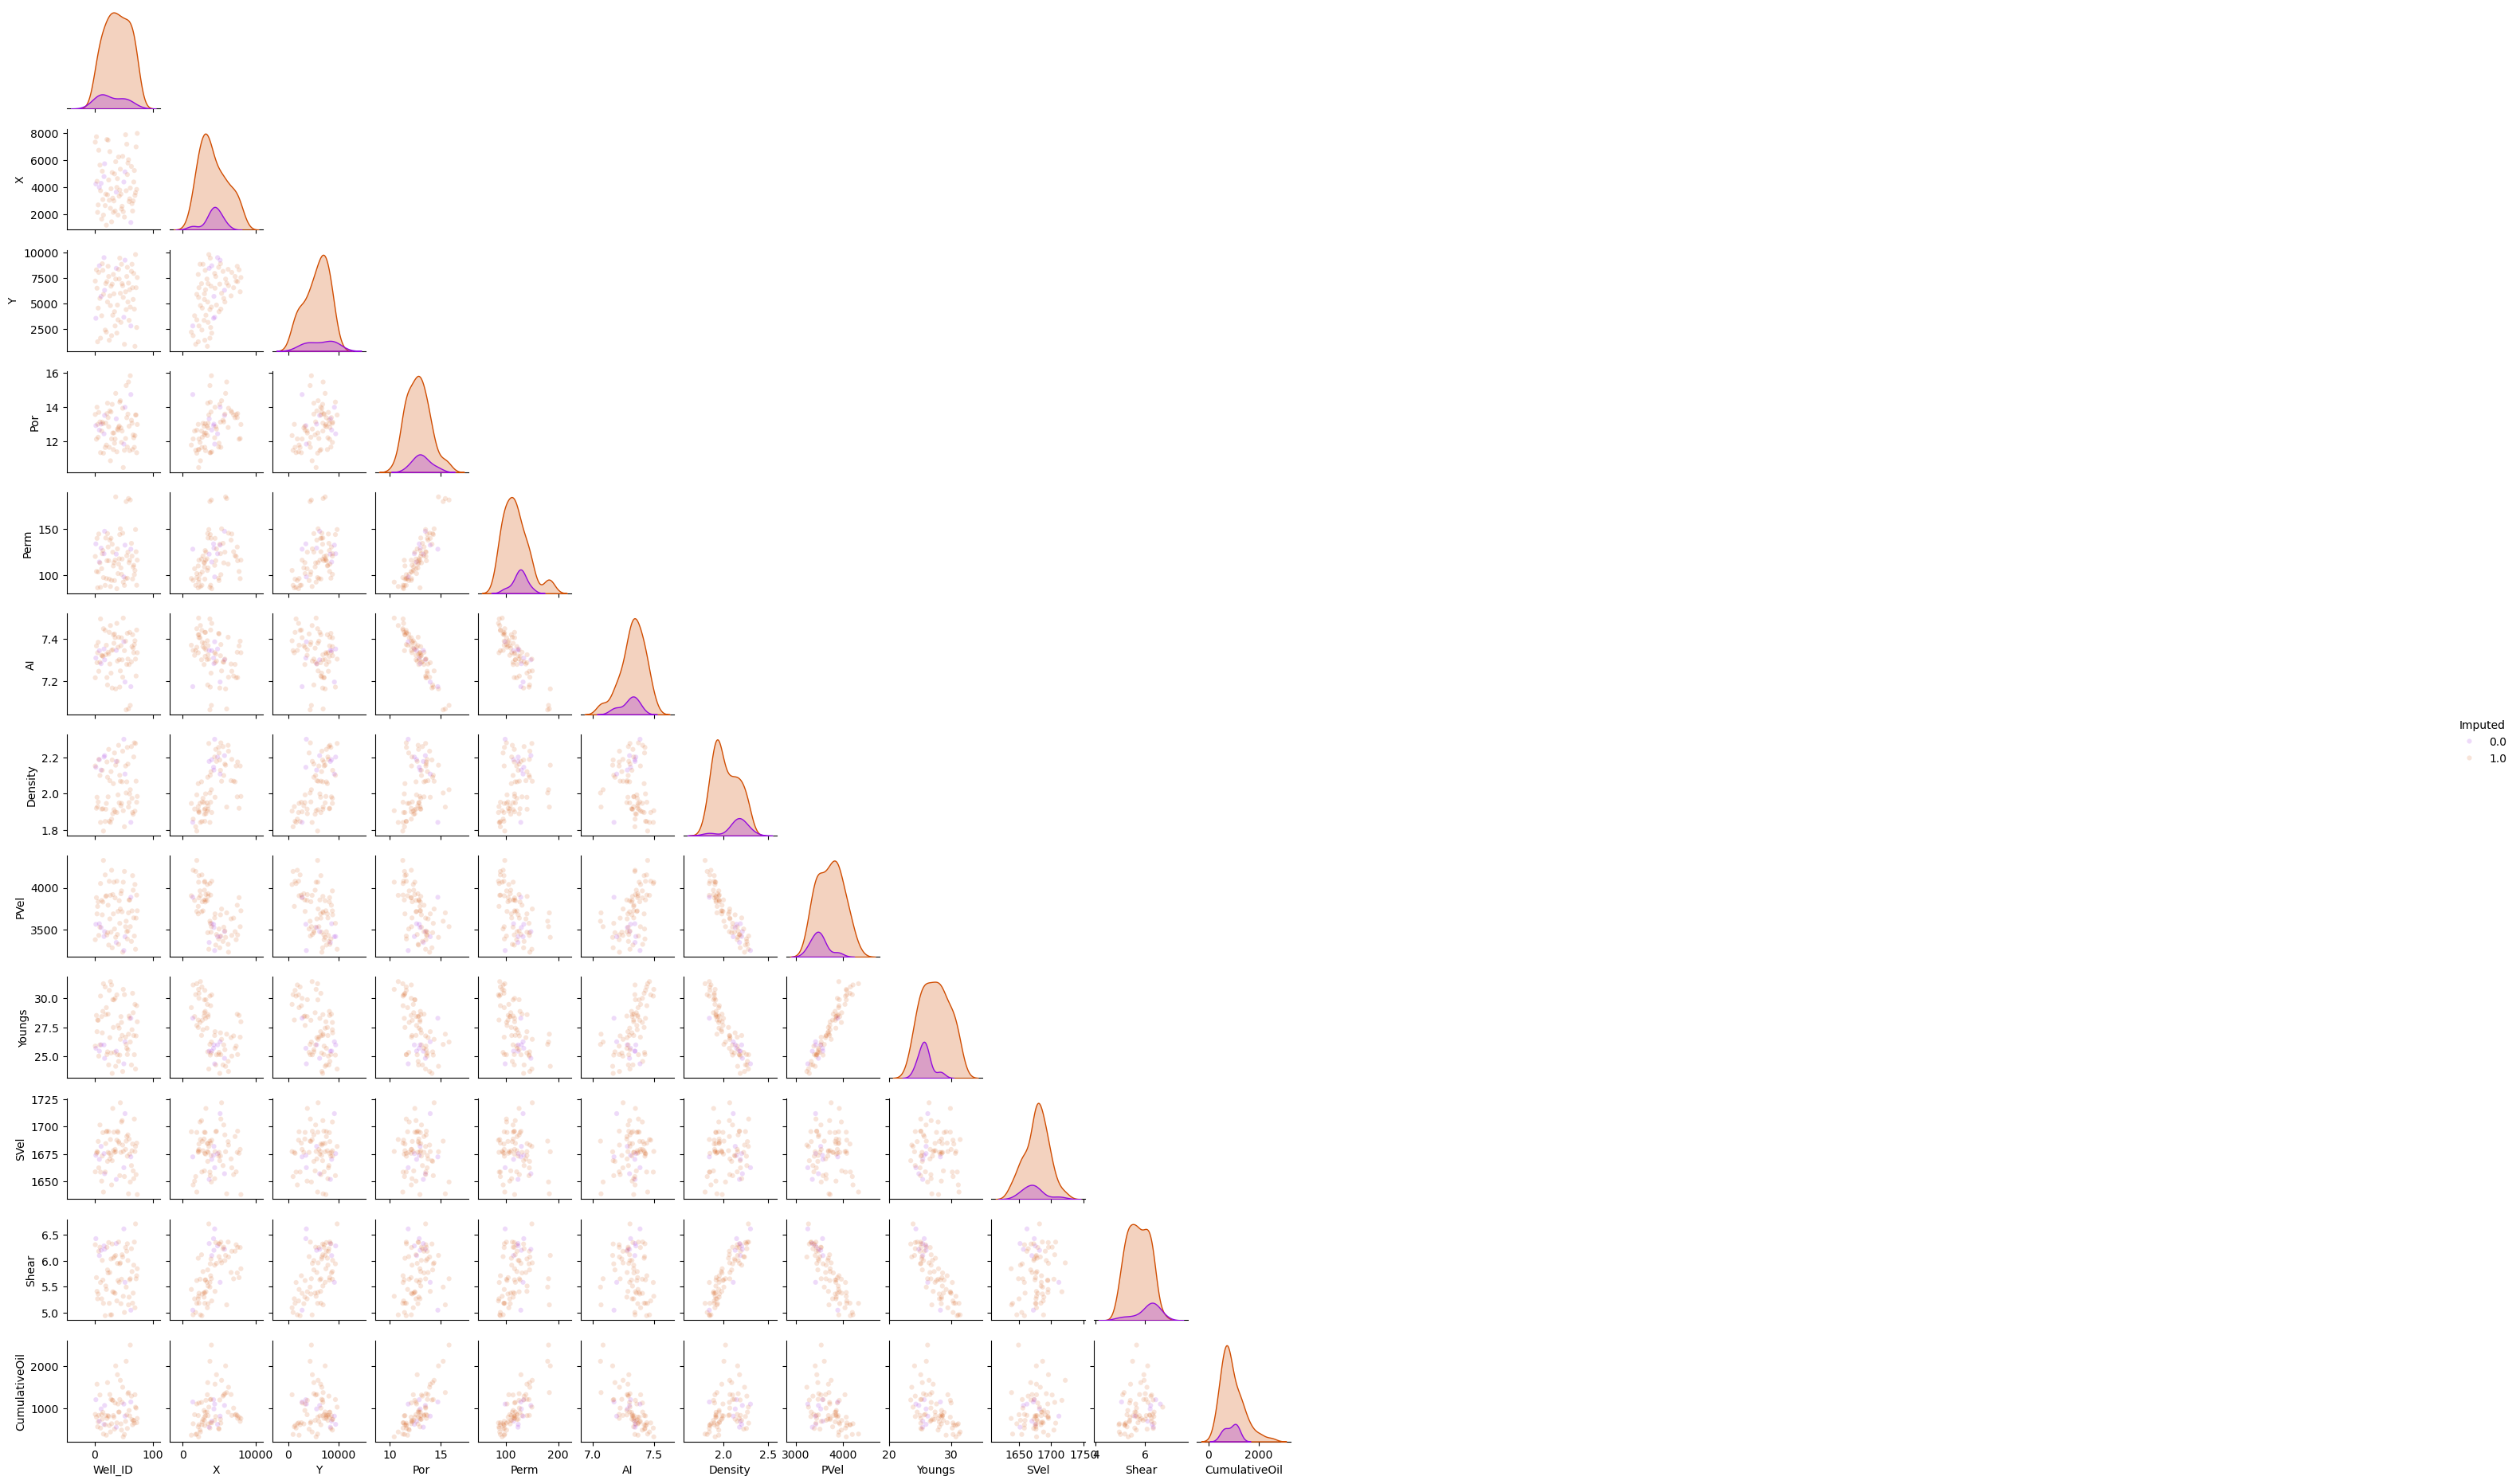

In [7]:
df_mice = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)

sns.pairplot(df_mice.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mode.head(n=5)

**Second Cut**

*Interpret data*
looking for data with simliar trends, high correlation, so we can cut those features in final predictions. The more features put in, the higher deminaity, and higher chance of it all turning into mush so we only put in the most important info with an effect. 
"C:\Users\alice\OneDrive\Pictures\Screenshots\Screenshot 2025-06-25 103902.png" 
Porsity x axis, permability y axis, direct correlation, we prob only need 1
"C:\Users\alice\OneDrive\Pictures\Screenshots\Screenshot 2025-06-25 104131.png"
Pvel x axis, Youngs y axis, direct correlation we prob only need 1
Another intresting find, Pvel and young both had strong inverse relationship with density

Expert Knowlege 

4. Porosity (fraction or %)
The fraction (or percentage) of the rock volume that consists of pore spaces, indicating the capacity of the rock to hold fluids (oil, gas, water).
5. Permeability (mD)
The ability of the rock to transmit fluids, measured in millidarcies (mD). Higher values mean fluids can flow more easily through the rock.
(makes sense why pores and permeabilty are related, but transmit fluid might be more important )
12. Compressional Velocity (m/s)
The speed at which compressional (P) seismic waves travel through the rock, measured in meters per second.

13. Young’s Modulus (GPa)
A measure of the rock’s stiffness, indicating how much it will deform under stress, measured in gigapascals.



Feature Ranking 


In [ ]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

In [8]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn import preprocessing                             # remove encoding error
from sklearn.feature_selection import RFE                     # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression  # mutual information
from sklearn.linear_model import LinearRegression             # linear regression model
from sklearn.ensemble import RandomForestRegressor            # model-based feature importance
from sklearn import metrics                                   # measures to check our models
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for random numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
import sys
#!{sys.executable} -m pip install shap
import shap
shap.initjs()

In [9]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)                  # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                                 # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                                  # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                            # assign as listed colormap
         
my_colormap = plt.cm.get_cmap('inferno', 256)                 # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                                    # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                                 # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors)                             # assign as listed colormap

In [ ]:
# Calculate correlation, rank correlation, and partial correlation for feature ranking


NameError: name 'x' is not defined

NameError: name 'feature_rank_plot' is not defined

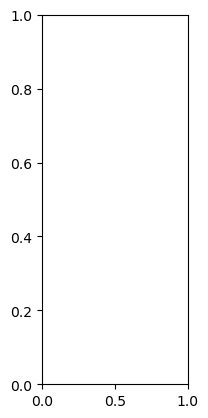

In [10]:
# plt.subplot(151)
# feature_rank_plot(features,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.1)

plt.subplot(131)
feature_rank_plot(features,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(132)
feature_rank_plot(features,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(133)
feature_rank_plot(features,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

# plt.subplot(155)
# feature_rank_plot(features,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2); plt.show()

In [ ]:
dfS = pd.DataFrame()                                          # Gaussian transform, standardization to a mean of 0 and variance of 1 

for feature in features:
    dfS[feature],d1,d2 = geostats.nscore(df,feature)

dfS.head()

NameError: name 'geostats' is not defined

In [ ]:
stand_covariance = dfS.iloc[:,dfS.columns.get_indexer(features)].cov().iloc[len(features)-1,:len(features)]
stand_correlation = dfS.iloc[:,dfS.columns.get_indexer(features)].corr().iloc[len(features)-1,:len(features)]

stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,dfS.columns.get_indexer(features)])
stand_rank_correlation = stand_rank_correlation[:,len(features)-1][:len(features)]
stand_partial_correlation = partial_corr(dfS.iloc[:,dfS.columns.get_indexer(features)]) # calculate the partial correlation coefficients
stand_partial_correlation = stand_partial_correlation[:,len(features)-1][:len(features)]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,dfS.columns.get_indexer(features)])    # calculate the semi-partial correlation coefficients
stand_semipartial_correlation = stand_semipartial_correlation[:,len(features)-1][:len(features)] 

NameError: name 'dfS' is not defined

In [ ]:
def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal)
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,mpred-0.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,mpred-0.5]); add_grid();
    plt.xticks(rotation=270.0)
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    plt.xticks(rotation=270.0)

def partial_corr(C):                                          # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                      # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                               # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                        # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):                   # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):                    # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [ ]:
idata = 2
if idata == 0:
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    response = 'Prod'                                             # specify the response feature
    x = df.copy(deep = True); x = x.drop(['Well',response],axis='columns') # make predictor and response DataFrames
    Y = df.loc[:,response]
    
    features = x.columns.values.tolist() + [Y.name]               # store the names of the features
    pred = x.columns.values.tolist()
    resp = Y.name
    
    xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minimum and maximum values for plotting
    Ymin = 500.0; Ymax = 9000.0
    
    predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
                 'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
    resplabel = 'Normalized Initial Production (MCFPD)'
    
    predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
                 'Total Organic Carbon','Vitrinite Reflectance']
    resptitle = 'Normalized Initial Production'
    
    featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
    featuretitle = predtitle + [resptitle]
    
    m = len(pred) + 1
    mpred = len(pred)
    
# elif idata == 1:
#     names = {'Porosity':'Por'}
    
#     df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load data from Dr. Pyrcz's GitHub repository  
#     df = df.rename(columns=names)
#     df['Por'] = df['Por'] * 100.0; df['AI'] = df['AI'] / 1000.0; 
#     df.drop('Unnamed: 0',axis=1,inplace=True) 
    
#     features = df.columns.values.tolist()                          # store the names of the features

#     xmin = [0.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [10000.0,10000.0,1.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
#     flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
#               'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

#     ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
#               'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

elif idata == 2:  
    df = pd.read_csv('/workspaces/hackathon-VictoriaAfnani/Pyrcz_ebook/dataframe_imputed.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    response = 'CumulativeOil'                                             # specify the response feature
    x = df.copy(deep = True); x = x.drop(['Well_ID','X','Y',response],axis='columns') # make predictor and response DataFrames
    Y = df.loc[:,response]
    
    features = x.columns.values.tolist() + [Y.name]               # store the names of the features
    pred = x.columns.values.tolist()
    resp = Y.name

    xmin = [1.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [75.0,10000.0,10000.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    Ymin = 0.0; Ymax = 3000.0
    
    predlabel = ['Well (ID)','X (m)','Y (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] 
    resplabel = 'Cumulative Production (MSTB)'
    
    predtitle = ['Well','X','Y','Porosity','Permeability','Acoustic Impedance',
              'Density (g/cm^3)','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus'] 
    resptitle = 'Cumulative Production'
    
    featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
    featuretitle = predtitle + [resptitle]
    
    m = len(pred) + 1
    mpred = len(pred)

In [ ]:
# plt.subplot(2,5,1)
# feature_rank_plot(features,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.5)

plt.subplot(2,3,1)
feature_rank_plot(features,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(2,3,2)
feature_rank_plot(features,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(2,3,3)
feature_rank_plot(features,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

# plt.subplot(2,5,5)
# feature_rank_plot(features,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

# plt.subplot(2,5,6)
# feature_rank_plot(features,stand_covariance,-1.0,1.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance of Standardized',0.5)

plt.subplot(2,3,4)
feature_rank_plot(features,stand_correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation of Standardized',0.5)

plt.subplot(2,3,5)
feature_rank_plot(features,stand_rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation of Standardized',0.5)

plt.subplot(2,3,6)
feature_rank_plot(features,stand_partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation of Standardized',0.5)

# plt.subplot(2,5,10)
# feature_rank_plot(features,stand_semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation of Standardized',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.3, hspace=0.3); plt.show()